In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
sns.set_theme()

# Importing the dataset

In [3]:
holidays = pd.read_csv('C:/Users/carlo/Downloads/holidays_events.csv', parse_dates=['date'])
oils = pd.read_csv('C:/Users/carlo/Downloads/oil.csv', parse_dates=['date'])
stores = pd.read_csv('C:/Users/carlo/Downloads/stores.csv')
transactions = pd.read_csv('C:/Users/carlo/Downloads/transactions(1).csv/transactions.csv', parse_dates=['date'])
test_df = pd.read_csv('C:/Users/carlo/Downloads/test.csv', parse_dates=['date'])
train_df = pd.read_csv('C:/Users/carlo/Downloads/train.csv/train.csv', parse_dates=['date'])

In [4]:
train_df.sample(10)

,id,date,store_nbr,family,sales,onpromotion
1681590,1681590,2015-08-04,41,DELI,165.486,0
1601354,1601354,2015-06-20,4,PREPARED FOODS,142.681,0
11915,11915,2013-01-07,43,BEAUTY,0.000,0
1771021,1771021,2015-09-23,50,EGGS,77.000,0
2903302,2903302,2017-06-22,20,POULTRY,142.247,0
977292,977292,2014-07-04,3,PRODUCE,6524.009,0
1778311,1778311,2015-09-27,6,CLEANING,1893.000,4
1517552,1517552,2015-05-04,39,HARDWARE,1.000,0
153851,153851,2013-03-28,26,BREAD/BAKERY,224.000,0
1495332,1495332,2015-04-22,16,BEVERAGES,358.000,0


In [5]:
test_df.sample(10)

,id,date,store_nbr,family,onpromotion
19510,3020398,2017-08-26,7,CLEANING,9
722,3001610,2017-08-16,29,PREPARED FOODS,1
22377,3023265,2017-08-28,37,BEVERAGES,35
16437,3017325,2017-08-25,20,BEVERAGES,21
2671,3003559,2017-08-17,33,SCHOOL AND OFFICE SUPPLIES,0
17274,3018162,2017-08-25,43,HOME AND KITCHEN I,1
23254,3024142,2017-08-29,11,"LIQUOR,WINE,BEER",2
4126,3005014,2017-08-18,25,BABY CARE,0
9158,3010046,2017-08-21,16,HOME APPLIANCES,0
13776,3014664,2017-08-23,45,HOME AND KITCHEN I,1


In [6]:
date = {}
date['date_start_train'] = '2017-04-30' #to avoid some peaks during May and April 2016 and same period of the test.
date['date_end_train'] = '2017-08-15'
date['date_end_test'] = '2017-08-31'
#test starts on '2017-08-16'

diff_test = (pd.Timestamp(date['date_end_test']) - pd.Timestamp(date['date_start_train'])).days
diff_train = (pd.Timestamp(date['date_end_train']) - pd.Timestamp(date['date_start_train'])).days

<AxesSubplot:xlabel='date'>

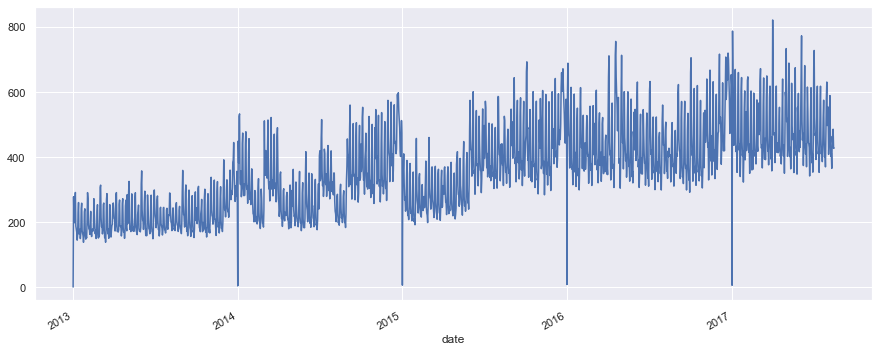

In [7]:
fig = plt.figure(figsize=(15,6))
train_df.groupby(by='date')['sales'].mean().plot()

# Stores

In [8]:
stores.sample(10)

,store_nbr,city,state,type,cluster
15,16,Santo Domingo,Santo Domingo de los Tsachilas,C,3
45,46,Quito,Pichincha,A,14
35,36,Libertad,Guayas,E,10
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
10,11,Cayambe,Pichincha,B,6
9,10,Quito,Pichincha,C,15
2,3,Quito,Pichincha,D,8
20,21,Santo Domingo,Santo Domingo de los Tsachilas,B,6
27,28,Guayaquil,Guayas,E,10


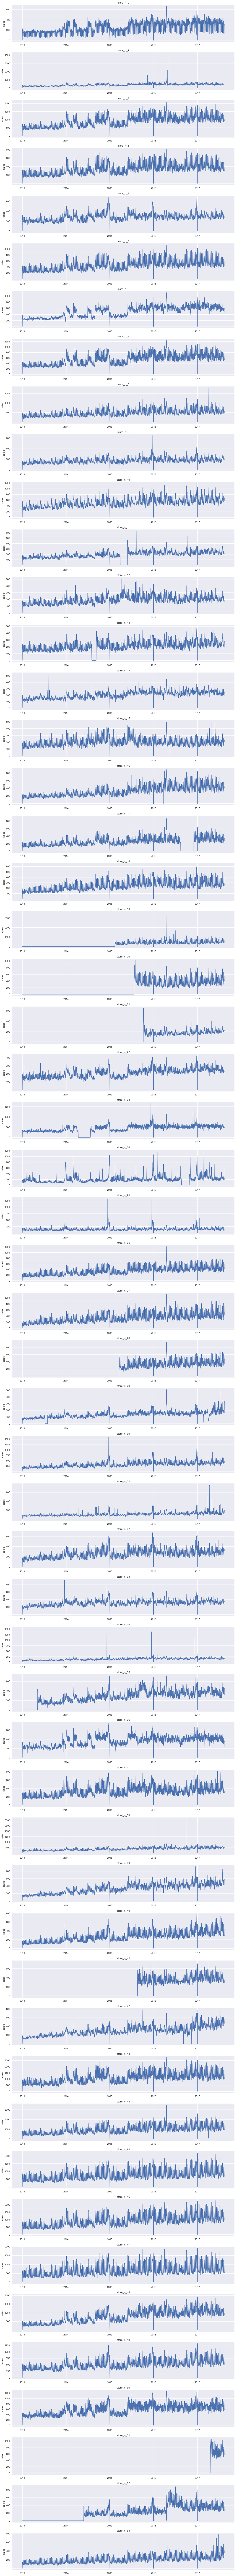

In [9]:
fig, axes = plt.subplots(54, 1, figsize=(15, 54*3))

for ax, i in zip(axes.flat, np.arange(0,54,1)):
    sns.lineplot(ax=axes[i], x=train_df[train_df.store_nbr==(i+1)].groupby(by='date')['sales'].mean().reset_index().date.values, y=train_df[train_df.store_nbr==(i+1)].groupby(by='date')['sales'].mean())
    ax.set_title(f'store_n_{i}') 
    
fig.tight_layout()

In [10]:
stores.groupby(by=['city']).store_nbr.nunique().sort_values(ascending=False)

city
Quito            18
Guayaquil         8
Santo Domingo     3
Cuenca            3
Manta             2
Machala           2
Latacunga         2
Ambato            2
Guaranda          1
Ibarra            1
Esmeraldas        1
Babahoyo          1
Loja              1
El Carmen         1
Daule             1
Playas            1
Puyo              1
Quevedo           1
Cayambe           1
Riobamba          1
Salinas           1
Libertad          1
Name: store_nbr, dtype: int64

In [11]:
def store (data):
    
    df = data.copy()
    
    # Adding features to stores
    df['uniquestore'] = df.city.apply(lambda x: 0 if x in ['Quito', 'Guayaquil', 'Santo Domingo', 'Cuenca', 'Manta', 'Machala', 'Latacunga', 'Ambato'] else 1)
    df['newstore'] = df.store_nbr.apply(lambda x: 1 if x in [19, 20, 21, 28, 35, 41, 51, 52] else 0)
        
    # Merging stores, test_df and train_df
    df = pd.concat([train_df, test_df], axis=0).merge(df, on=['store_nbr'], how='left')
    df = df.rename(columns={'type' : 'store'}) 

    return df

In [12]:
final_df = store(stores)

In [13]:
final_df

,id,date,store_nbr,family,sales,onpromotion,city,state,store,cluster,uniquestore,newstore
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0,0
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0,0
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0,0
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,0,0


# Holidays

In [14]:
holidays.sample(10)

,date,type,locale,locale_name,description,transferred
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
50,2013-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
18,2012-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
189,2015-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
221,2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False
232,2016-04-28,Event,National,Ecuador,Terremoto Manabi+12,False
112,2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
237,2016-05-02,Event,National,Ecuador,Terremoto Manabi+16,False


In [15]:
holidays[holidays[['date', 'locale_name']].duplicated()]

,date,type,locale,locale_name,description,transferred
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
40,2012-12-31,Additional,National,Ecuador,Primer dia del ano-1,False
157,2014-12-26,Additional,National,Ecuador,Navidad+1,False
236,2016-05-01,Event,National,Ecuador,Terremoto Manabi+15,False
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False
245,2016-05-08,Event,National,Ecuador,Dia de la Madre,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False


In [16]:
train_df.groupby(by=['store_nbr','date'])['sales'].mean().reset_index().query("date.dt.month==1 and date.dt.day==1").sample(10)
#no es ven el primer dia de l'any = el local està tancat

,store_nbr,date,sales
51248,31,2015-01-01,0.0
32360,20,2014-01-01,0.0
67724,41,2014-01-01,0.0
65084,39,2016-01-01,0.0
8784,6,2014-01-01,0.0
65449,39,2017-01-01,0.0
33680,21,2013-01-01,0.0
71456,43,2015-01-01,0.0
57029,34,2017-01-01,0.0
61716,37,2016-01-01,0.0


In [17]:
holidays.query("transferred==True")

,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


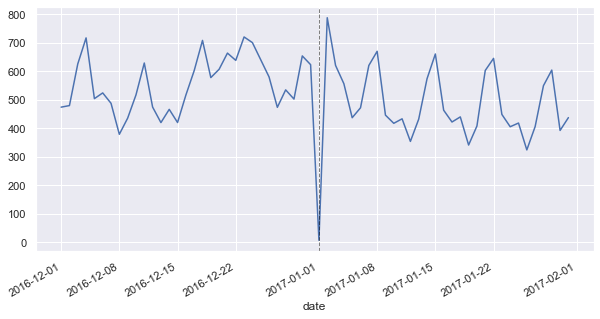

In [18]:
fig = plt.figure(figsize=(10,5))
train_df.query("(date.dt.year==2017 and date.dt.month==1) or (date.dt.year==2016 and date.dt.month==12)").groupby(by='date')['sales'].mean().plot()
plt.axvline(x=pd.Timestamp('2017-01-01'), color='black', linestyle='--', linewidth=1, alpha=0.5)
#comprovem

In [19]:
holidays.query("date.dt.month==1 and date.dt.day==1")

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
92,2014-01-01,Holiday,National,Ecuador,Primer dia del ano,False
159,2015-01-01,Holiday,National,Ecuador,Primer dia del ano,False
211,2016-01-01,Holiday,National,Ecuador,Primer dia del ano,False
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True


In [20]:
def holiday (data):
    
    df = data.copy()
    
    # Non-transferred events
    df.loc[297, 'transferred'] = df.loc[297, 'transferred'] = False
    df = df.query("transferred!=True")

    # 'Good Friday' mistake correction
    df['date'] = df['date'].replace({'2013-04-29' : pd.to_datetime('2013-03-29')}) 
    
    # Removing duplicates
    df = df.drop(index=holidays[holidays[['date', 'locale_name']].duplicated()].index.values)

    # Adding event type
    df.loc[df.type=='Event', 'type'] = df.description.apply(lambda x: x[0:7])
     
    # Merging holidays and final_df
    nat_df = df.query("locale=='National'")
    df = final_df.merge(nat_df, left_on=['date'], right_on=['date'], how='left')

    # Work days
    df['wd'] = True
    df.loc[df.type == 'Bridge'  , 'wd'] = False
    df.loc[df.type == 'Transfer', 'wd'] = False
    df.loc[(df.type == 'Additional') & (df.transferred == False), 'wd'] = False
    df.loc[(df.type == 'Holiday') & (df.transferred == False), 'wd'] = False  
    
    #Adding Easter
    easter_dates = ['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']    
    df.loc[df['date'].isin(easter_dates), 'wd'] = False
    df.loc[df['date'].isin(easter_dates), 'type'] = 'Holiday'

    df['isevent'] = False
    df.loc[df.type == 'Event'  , 'isevent'] = True
    df.loc[df['date'].isin(easter_dates), 'isevent'] = True

   
    # Adding New Year
    df['firstday'] = df.description.apply(lambda x: 1 if x=='Primer dia del ano' else 0)
    df.loc[df['firstday'] == 1, 'type'] = 'Holiday'
    df = df.drop(columns=['locale', 'locale_name', 'description', 'transferred'])

    # Adding closure days
    df['isclosed'] = df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum()==0 else 0)    
    df.loc[(df.date.dt.year==2017) & (df.date.dt.month==8) & (df.date.dt.day>=16) , 'isclosed'] = df.isclosed.apply(lambda x: 0)    
    df.loc[df.date.isin(['2017-01-01']), 'isevent'] = df.isevent.apply(lambda x: 'n')
    
    return df

In [21]:
final_df = holiday(holidays)

C:\Users\carlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [22]:
final_df

,id,date,store_nbr,family,sales,onpromotion,city,state,store,cluster,uniquestore,newstore,type,wd,isevent,firstday,isclosed
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0,0,Holiday,False,False,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0,0,Holiday,False,False,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0,0,Holiday,False,False,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0,0,Holiday,False,False,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0,0,Holiday,False,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0,0,NaN,True,False,0,0
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0,0,NaN,True,False,0,0
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0,0,NaN,True,False,0,0
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,0,0,NaN,True,False,0,0


In [23]:
# Extract event or holiday from holidays
event_holiday = final_df[(final_df['type'] == 'Bridge') | (final_df['type'] == 'Holiday')]
# rename to ds and holiday as required
event_holiday = event_holiday[['date', 'type']].rename(columns = {'date': 'ds', 'type': 'holiday'})

In [24]:
event_holiday = event_holiday.to_csv('event_holiday.csv')